In [1]:
import matplotlib.pyplot as pp
import pandas as pd
import seaborn as sb
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.imputation as smi
import statsmodels.stats.api as sms

from pandas.api.types import CategoricalDtype
from sklearn.impute import SimpleImputer

## Data loading

Let's load our dataset.
We will use a diabetes dataset from class which I have added some missing values to.

In [2]:
file_name = "../data/diabetes_missing.csv"
df = pd.read_csv(file_name)
df.head()

,Random Blood Glucose mg/dL,Random Blood Glucose Binary,Random Blood Glucose Ordinal,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,TCH,LTG,Fasting Glucose
0,151,Low,Medium,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87.0
1,75,Low,Low,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69.0
2,141,Low,Low,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85.0
3,206,High,High,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89.0
4,135,Low,Low,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80.0


Let's take a quick look at the size of the dataset with `shape`.

In [3]:
df.shape

(442, 13)

## Exploratory data analysis

We have 442 observations (rows) and 13 variables (columns).
A first way to see if you have missing values is to use the describe function.

In [4]:
df.describe()

,Random Blood Glucose mg/dL,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,TCH,LTG,Fasting Glucose
count,442.000000,442.000000,442.000000,420.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,380.000000
mean,152.133484,48.518100,1.468326,26.390714,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,90.968421
std,77.093005,13.109028,0.499561,4.404298,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,11.336031
min,25.000000,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,60.000000
25%,87.000000,38.250000,1.000000,23.275000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,83.000000
50%,140.500000,50.000000,1.000000,25.700000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,91.000000
75%,211.500000,59.000000,2.000000,29.225000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,98.000000
max,346.000000,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


We can see from the count row that "BMI" and "Fasting Glucose" have fewer entries than the other variables and less than 442 our number of observations.

We can also directly compute the number of missing values with the `isna` method and the `sum` method.
The `isna` method will return a matrix of True/False values indicating whether a value is missing (na).
Calling `sum` on that matrix will add the entries for column together, treating False (not missing) as zero and True (missing) as one.

In [5]:
df.isna().sum()

Random Blood Glucose mg/dL       0
Random Blood Glucose Binary      0
Random Blood Glucose Ordinal     0
Age                              0
Sex                              0
BMI                             22
BP                               0
Total Cholesterol                0
LDL                              0
HDL                              0
TCH                              0
LTG                              0
Fasting Glucose                 62
dtype: int64

## Removing missing values

The most conservative approach for dealing with missing values is to remove any row with a missing value.
We can do this using the `dropna` method.
Doing this means any row with a missing value anywhere will be removed.

In [6]:
df_remove = df.dropna(axis=0)
df_remove.shape

(360, 13)

We can look at how much of the data remains by taking the ratio of rows in the new data frame to the original.

In [7]:
df_remove.shape[0] / df.shape[0]

0.8144796380090498

## Imputing with the mean

A less conservative approach is to replace missing values with the mean of the column.
This approach by construction does not change the mean of the distribution for that column, but will alter the variance.
We can do this using pandas indexing fairly easily.
Below I am making a copy of the original data so we can compare the results.

#### Manual filling

In [8]:
df_mean = df.copy()
df_mean.loc[df_mean["BMI"].isna(), "BMI"] = df_mean["BMI"].mean()
df_mean.loc[df_mean["Fasting Glucose"].isna(), "Fasting Glucose"] = df_mean[
    "Fasting Glucose"
].mean()
df_mean.describe()

,Random Blood Glucose mg/dL,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,TCH,LTG,Fasting Glucose
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,152.133484,48.518100,1.468326,26.390714,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,90.968421
std,77.093005,13.109028,0.499561,4.293034,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,10.508999
min,25.000000,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,60.000000
25%,87.000000,38.250000,1.000000,23.325000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,84.250000
50%,140.500000,50.000000,1.000000,25.950000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,90.968421
75%,211.500000,59.000000,2.000000,28.875000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,96.000000
max,346.000000,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


#### Using pandas

The same result can also be achieved more compactly with the [fillna](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html) method.

In [9]:
df_mean = df.copy()
df_mean["BMI"] = df["BMI"].fillna(df["BMI"].mean())
df_mean["Fasting Glucose"] = df["Fasting Glucose"].fillna(df["Fasting Glucose"].mean())
df_mean.describe()

,Random Blood Glucose mg/dL,Age,Sex,BMI,BP,Total Cholesterol,LDL,HDL,TCH,LTG,Fasting Glucose
count,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000,442.000000
mean,152.133484,48.518100,1.468326,26.390714,94.647014,189.140271,115.439140,49.788462,4.070249,4.641411,90.968421
std,77.093005,13.109028,0.499561,4.293034,13.831283,34.608052,30.413081,12.934202,1.290450,0.522391,10.508999
min,25.000000,19.000000,1.000000,18.000000,62.000000,97.000000,41.600000,22.000000,2.000000,3.258100,60.000000
25%,87.000000,38.250000,1.000000,23.325000,84.000000,164.250000,96.050000,40.250000,3.000000,4.276700,84.250000
50%,140.500000,50.000000,1.000000,25.950000,93.000000,186.000000,113.000000,48.000000,4.000000,4.620050,90.968421
75%,211.500000,59.000000,2.000000,28.875000,105.000000,209.750000,134.500000,57.750000,5.000000,4.997200,96.000000
max,346.000000,79.000000,2.000000,42.200000,133.000000,301.000000,242.400000,99.000000,9.090000,6.107000,124.000000


We can plot the results.
Note that I have to create a figure and an axes which is shared between the two plots.
I did this so we could see both results together.
I also made some modifications to the colors and alpha scaling of the plots so we could see them despite the overlap.

(<Axes: >, <Axes: >)

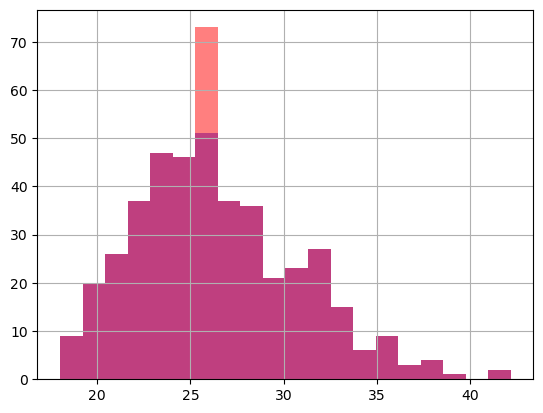

In [10]:
fig = pp.figure()
ax = fig.add_subplot(1, 1, 1)
df["BMI"].hist(ax=ax, bins=20, alpha=0.5, color="b"), df_mean["BMI"].hist(
    ax=ax, bins=20, alpha=0.5, color="r"
)

Now lets compare the descriptive statistics.

In [11]:
df["BMI"].describe(), df_mean["BMI"].describe()

(count    420.000000
 mean      26.390714
 std        4.404298
 min       18.000000
 25%       23.275000
 50%       25.700000
 75%       29.225000
 max       42.200000
 Name: BMI, dtype: float64,
 count    442.000000
 mean      26.390714
 std        4.293034
 min       18.000000
 25%       23.325000
 50%       25.950000
 75%       28.875000
 max       42.200000
 Name: BMI, dtype: float64)

#### Using scikit-learn

All this can further be simplified if we use the [`SimpleImputer`](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html#sklearn.impute.SimpleImputer) class from the scikit-learn (`sklearn`).
The `sklearn` package can do more sophisticated things if for example columns are categorical, but handling this is beyond the scope of the course.

Note I am passing the `strategy` argument explicitly.
By default it is mean, so this is unecessary, but it is helpful for code readability.
Other strategies such as median exist for continuous values as well.

In [12]:
df_mean[["BMI", "Fasting Glucose"]] = SimpleImputer(strategy="mean").fit_transform(
    df[["BMI", "Fasting Glucose"]]
)
df_mean["BMI"].describe()

count    442.000000
mean      26.390714
std        4.293034
min       18.000000
25%       23.325000
50%       25.950000
75%       28.875000
max       42.200000
Name: BMI, dtype: float64

## Multiple Imputation with Chained Equations

A more sophisticated way of performing imputation is to use Multiple Imputation with Chained Equations ([MICE](multiple imputation with chained equations)).
Unlike the simple strategies used so far, MICE is typically used as part of an analysis.
Here we will perform a multivariable linear regression to predict "Random Blood Glucose mg/dL".
The `statsmodel` package provides support for this.

First I will get rid of the categorical and ordinal encodings of our dependent variable.

I am also going to get cleanup some column names to make writing the formulas easier.

In [13]:
df_imp = df.drop(["Random Blood Glucose Binary", "Random Blood Glucose Ordinal"], axis=1)
df_imp = df_imp.rename(columns={
    "Random Blood Glucose mg/dL": "RBG",
    "Total Cholesterol": "TC",
    "Fasting Glucose": "FG"
})
df_imp.head()

,RBG,Age,Sex,BMI,BP,TC,LDL,HDL,TCH,LTG,FG
0,151,59,2,32.1,101.0,157,93.2,38.0,4.0,4.8598,87.0
1,75,48,1,21.6,87.0,183,103.2,70.0,3.0,3.8918,69.0
2,141,72,2,30.5,93.0,156,93.6,41.0,4.0,4.6728,85.0
3,206,24,1,25.3,84.0,198,131.4,40.0,5.0,4.8903,89.0
4,135,50,1,23.0,101.0,192,125.4,52.0,4.0,4.2905,80.0


First let's try fitting a regression without dealing with the missing values.

In [14]:
model = smf.ols('RBG ~ BP + BMI + FG', data=df_imp)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    RBG   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     86.21
Date:                Tue, 08 Jul 2025   Prob (F-statistic):           5.97e-42
Time:                        11:45:51   Log-Likelihood:                -1978.0
No. Observations:                 360   AIC:                             3964.
Df Residuals:                     356   BIC:                             3979.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -247.8748     28.807     -8.605      0.000    -304.527    -191.222
BP             1.1611      0.257      4.524      0.000       0.656       1.666
BMI            8.1128      0.786     10.324      0.000       6.567       9.658
FG             0.8084      0.316      2.558      0.011       0.187       1.430
==============================================================================
Omnibus:                       12.490   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.002   Jarque-Bera (JB):                6.651
Skew:                           0.117   Prob(JB):                       0.0360
Kurtosis:                       2.377   Cond. No.                     1.24e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

You'll note that only 360 observations are included because `statsmodels` has ignore the entries with missing values.

Now we can setup the imputation analysis.

In [15]:
imp = smi.mice.MICEData(df_imp)
fml = 'RBG ~ BP + BMI + FG'
mice = smi.mice.MICE(fml, sm.OLS, imp)
results = mice.fit()
results.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                            Results: MICE
======================================================================
Method:                    MICE        Sample size:            442    
Model:                     OLS         Scale                   3549.65
Dependent variable:        RBG         Num. imputations        10     
----------------------------------------------------------------------
            Coef.   Std.Err.    t    P>|t|    [0.025    0.975]   FMI  
----------------------------------------------------------------------
Intercept -249.3009  26.8469 -9.2860 0.0000 -301.9199 -196.6819 0.0362
BP           1.1947   0.2356  5.0719 0.0000    0.7330    1.6564 0.0112
BMI          7.9277   0.7330 10.8154 0.0000    6.4910    9.3643 0.0293
FG           0.8670   0.3005  2.8853 0.0039    0.2781    1.4560 0.0984
======================================================================

"""

Now we can see that the sample size is 442, implying all the data was used.

The results can now be analysed like a standard linear regression.

> You can also get imputed values out of the `MICEData` object, but that is beyond the scope of this tutorial.